# Q2: 买什么？

Q1 我们用一只沪深300ETF 体验了量化策略的完整闭环。但只买一只够吗？

趋势交易赚的是"每次赚一点、覆盖多个标的加起来"的钱——单个标的上不可能买在最低卖在最高，所以需要广撒网、分散风险。那问题来了：**该选哪些标的？**

### 路线图

从 Q2 开始，我们要把 Q1 的闭环拆开，一步步做扎实：

**选什么标的（Q2）→ 每个买多少（Q3）→ 什么时候买卖（Q4）→ 怎么验证有效（Q5）**

本章解决第一步。分三个小步回答：**选什么类型 → 选哪个地区 → 怎么保护组合**

从现在起，每个决策都遵循一个铁律：**先猜后验，数据说了算。**

### 工具升级

从本章起，我们使用专业的量化框架 **open-xquant**。Q1 帮你建立了直觉，现在用更专业的工具。

### 前置条件

- 已完成 Q1
- 已安装 open-xquant：`pip install open-xquant[yfinance,akshare]`

### 操作方式

和 Q1 一样：阅读说明 → 打开对应 spec → 复制到 TRAE → 观察结果 → 回来看解读。

---

## Step 1: 先拿几只股票试试

Q1 用的是沪深300ETF，但大家更熟悉的是个股——茅台、平安、招商银行这些耳熟能详的名字。能不能直接对它们跑均线策略？

我们来试试。挑 5 只知名 A 股，用 Q1 学的均线策略跑一遍，和沪深300ETF 做个对比。

👉 **打开 `specs/spec-01-signal-quality.md`，复制到 TRAE。**

均线策略回测结果（20日均线，最近3年）
600519.SS (贵州茅台): 收益率  -5.95%
000858.SZ (五粮液): 收益率  -7.75%
601318.SS (中国平安): 收益率  36.80%
000001.SZ (平安银行): 收益率  13.05%
600036.SS (招商银行): 收益率  27.62%
510300.SS (沪深300ETF): 收益率  12.48%


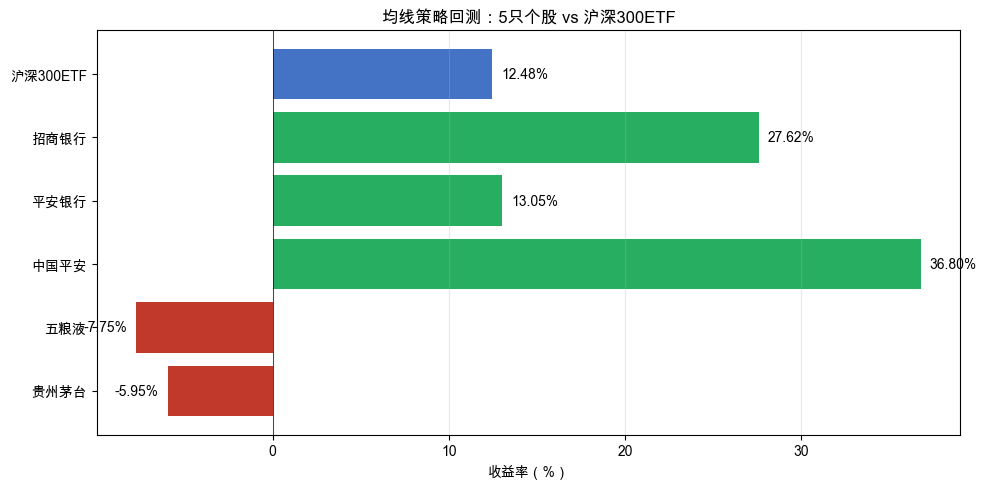


同样的均线策略，5 只个股的结果天差地别——从大幅盈利到严重亏损都有。
单只股票波动大、不可预测，但沪深300ETF 包含 300 只股票，个股的噪音互相抵消，表现更稳定。
组合能对抗波动。ETF 就是一种组合。


In [1]:
from oxq.data import YFinanceDownloader, LocalMarketDataProvider
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']
plt.rcParams['axes.unicode_minus'] = False

# 初始化 open-xquant
today = pd.Timestamp.now().strftime("%Y-%m-%d")
three_years_ago = (pd.Timestamp.now() - pd.DateOffset(years=3)).strftime("%Y-%m-%d")
downloader = YFinanceDownloader()
provider = LocalMarketDataProvider()

# 下载沪深300ETF
downloader.download("510300.SS", start=three_years_ago, end=today)

# 下载 5 只 A 股个股
stock_symbols = ["600519.SS", "000858.SZ", "601318.SS", "000001.SZ", "600036.SS"]
stock_names = ["贵州茅台", "五粮液", "中国平安", "平安银行", "招商银行"]

for symbol in stock_symbols:
    downloader.download(symbol, start=three_years_ago, end=today)


def simple_ma_backtest(bars, ma_period=20):
    """简单均线策略回测：收盘价上穿均线买入，下穿均线卖出"""
    close = bars['close'].values
    ma = pd.Series(close).rolling(ma_period).mean().values

    position = 0  # 0=空仓, 1=持仓
    total_return = 0.0
    entry_price = 0.0

    for i in range(ma_period, len(close)):
        if close[i] > ma[i] and position == 0:  # 上穿均线，买入
            position = 1
            entry_price = close[i]
        elif close[i] < ma[i] and position == 1:  # 下穿均线，卖出
            position = 0
            total_return += (close[i] - entry_price) / entry_price

    # 如果最后仍持仓，按最后收盘价结算
    if position == 1:
        total_return += (close[-1] - entry_price) / entry_price

    return total_return


# 对 5 只个股 + 沪深300ETF 分别运行回测
all_symbols = stock_symbols + ["510300.SS"]
all_names = stock_names + ["沪深300ETF"]
results = {}

print("均线策略回测结果（20日均线，最近3年）")
print("=" * 50)

for symbol, name in zip(all_symbols, all_names):
    bars = provider.get_bars(symbol, start=three_years_ago, end=today)
    ret = simple_ma_backtest(bars)
    results[name] = ret
    print(f"{symbol} ({name}): 收益率 {ret:7.2%}")

# 横向柱状图
fig, ax = plt.subplots(figsize=(10, 5))

names = list(results.keys())
returns = list(results.values())

# 颜色规则：沪深300ETF 蓝色高亮，其余按正负区分绿色/红色
colors = []
for name, ret in zip(names, returns):
    if name == "沪深300ETF":
        colors.append("#4472C4")  # 蓝色高亮
    elif ret >= 0:
        colors.append("#27AE60")  # 正收益绿色
    else:
        colors.append("#C0392B")  # 负收益红色

bars = ax.barh(names, [r * 100 for r in returns], color=colors)

# 在柱子旁标注数值
for bar, ret in zip(bars, returns):
    x = bar.get_width()
    offset = 0.5 if x >= 0 else -0.5
    ax.text(x + offset, bar.get_y() + bar.get_height()/2,
            f'{ret:.2%}', va='center', fontsize=10,
            ha='left' if x >= 0 else 'right')

ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('收益率（%）')
ax.set_title('均线策略回测：5只个股 vs 沪深300ETF')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n同样的均线策略，5 只个股的结果天差地别——从大幅盈利到严重亏损都有。")
print("单只股票波动大、不可预测，但沪深300ETF 包含 300 只股票，个股的噪音互相抵消，表现更稳定。")
print("组合能对抗波动。ETF 就是一种组合。")

### Step 1 解读

柱状图一目了然：**同样的策略，个股之间的差异大到离谱。**

这不是策略的问题，而是个股本身的问题——每只股票的走势受太多独有因素影响（行业政策、公司财报、管理层变动、市场情绪……），趋势信号被淹没在噪音里。

但你有没有注意到，沪深300ETF 的结果相对稳定？它本身就是 300 只股票的**组合**——个股的噪音互相抵消，留下的是更纯粹的市场趋势。

**数据说了算：单只股票波动大、不可预测，但组合能对抗这种波动。** ETF 就是一种组合。后面我们还会看到，多只 ETF 放在一起，是组合的组合——同一个原理，层层叠加。

### 组合的力量

Q0 我们说过，ETF 是"一篮子股票的打包组合"。当时的理由是"适合新手"。现在你有了更深的理解：

**组合能对抗单只股票的噪音。** 刚才的实验证明了这一点——同样的策略，300 只股票的组合比任何单只股票的表现都更稳定、更可预测。

从"选哪只股票"变成"选哪只 ETF"，问题也一下子简化了——全球 ETF 加起来也就几百只，远比 5000 只个股容易处理。

---

## Step 2: 几百只 ETF，选哪几只？

好，用 ETF。但全球 ETF 有几百只，总不能全买。怎么缩小范围？

最直觉的思路：**经济最强的国家，资本市场应该最有潜力。** 真的吗？我们拿数据看看。

👉 **打开 `specs/spec-02-gdp-anchor.md`，复制到 TRAE。**

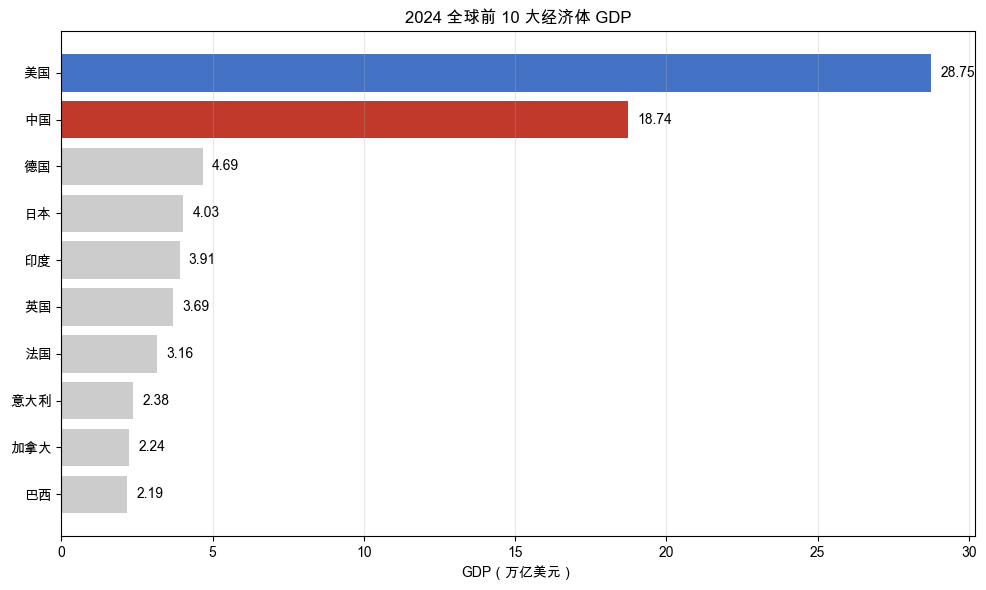

中美两国 GDP 远超其他国家，合计占全球 GDP 的约 40%。
最直觉的思路：经济最强的国家，资本市场应该最有潜力。
数据说了算：锁定中国（沪深300 ETF）和美国（纳斯达克100 ETF）



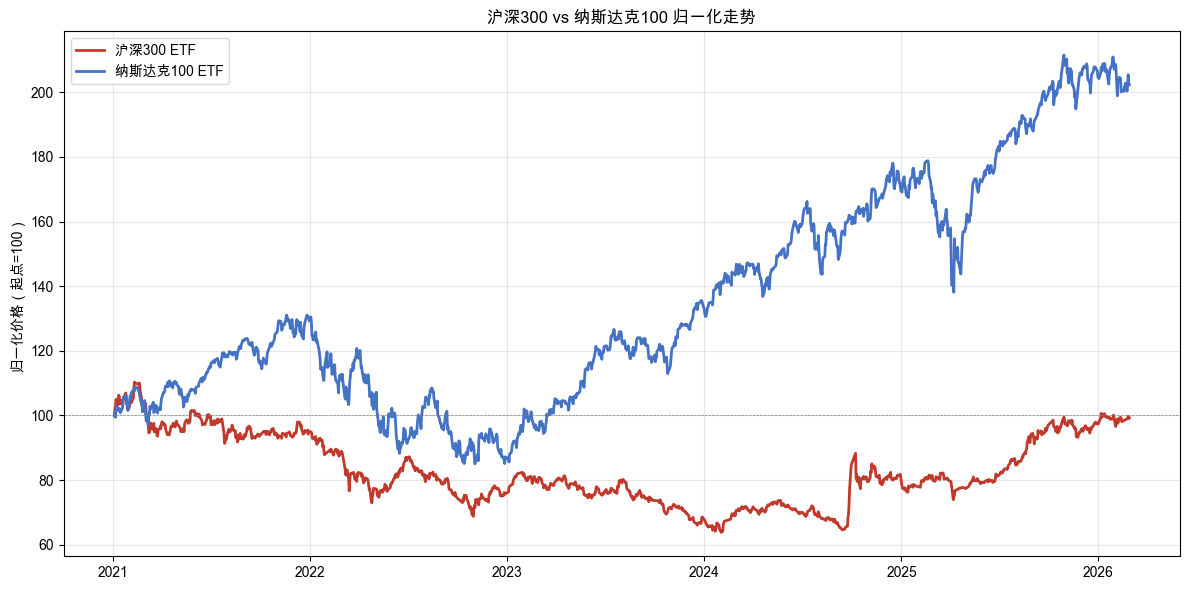

但一个新问题出现了——如果中美股市同时下跌怎么办？


In [2]:
from oxq.data import WorldBankDownloader, read_factor

# 下载全球前 10 大经济体 GDP 数据
wb = WorldBankDownloader()
countries = ["USA", "CHN", "DEU", "JPN", "IND", "GBR", "FRA", "ITA", "BRA", "CAN"]
wb.download("gdp", countries=countries, start_year=2020, end_year=2024)

# 读取 GDP 数据，取最新一年，转换为万亿美元
gdp_raw = read_factor("gdp", countries=countries, start_year=2020, end_year=2024)
latest_year = gdp_raw.index.max()
gdp_latest = gdp_raw.loc[latest_year] / 1e12  # 转换为万亿美元

# 国家代码 → 中文名
country_names = {
    'USA': '美国', 'CHN': '中国', 'DEU': '德国', 'JPN': '日本',
    'IND': '印度', 'GBR': '英国', 'FRA': '法国', 'ITA': '意大利',
    'BRA': '巴西', 'CAN': '加拿大'
}

gdp_data = pd.DataFrame({
    '国家': [country_names[c] for c in gdp_latest.index],
    'GDP': gdp_latest.values
}).sort_values('GDP', ascending=False).reset_index(drop=True)

# GDP 横向柱状图
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4472C4' if c == '美国' else '#C0392B' if c == '中国' else '#CCCCCC'
          for c in gdp_data['国家']]
bars = ax.barh(gdp_data['国家'][::-1], gdp_data['GDP'][::-1], color=colors[::-1])

for bar, val in zip(bars, gdp_data['GDP'][::-1]):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', va='center', fontsize=10)

ax.set_xlabel('GDP（万亿美元）')
ax.set_title(f'{latest_year} 全球前 10 大经济体 GDP')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("中美两国 GDP 远超其他国家，合计占全球 GDP 的约 40%。")
print("最直觉的思路：经济最强的国家，资本市场应该最有潜力。")
print("数据说了算：锁定中国（沪深300 ETF）和美国（纳斯达克100 ETF）\n")

# 下载两只 ETF
downloader.download("510300.SS", start="2021-01-01", end=today)
downloader.download("QQQ", start="2021-01-01", end=today)

# 读取数据并归一化对比
csi300 = provider.get_bars("510300.SS", start="2021-01-01", end=today)
qqq = provider.get_bars("QQQ", start="2021-01-01", end=today)

# 归一化到起点 = 100
csi300_norm = csi300['close'] / csi300['close'].iloc[0] * 100
qqq_norm = qqq['close'] / qqq['close'].iloc[0] * 100

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(csi300_norm.index, csi300_norm.values, label='沪深300 ETF', linewidth=2, color='#C0392B')
ax.plot(qqq_norm.index, qqq_norm.values, label='纳斯达克100 ETF', linewidth=2, color='#4472C4')
ax.axhline(y=100, color='gray', linestyle='--', linewidth=0.5)
ax.set_ylabel('归一化价格（起点=100）')
ax.set_title('沪深300 vs 纳斯达克100 归一化走势')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("但一个新问题出现了——如果中美股市同时下跌怎么办？")

### Step 2 解读

GDP 数据给了我们一个清晰的锚点：中国和美国是全球经济的两大引擎，合计占全球 GDP 约 40%，远超其他国家。

对应到投资标的：
- **沪深300 ETF** → 中国最大的 300 家公司
- **纳斯达克100 ETF** → 美国科技成长龙头（苹果、微软、英伟达等）

**数据说了算：锁定中美。**

归一化走势图还揭示了一个有趣的现象：两个市场的涨跌节奏并不完全同步——这是好事，意味着它们之间存在天然的分散效果。

但一个新问题出现了：**如果某段时间中美碰巧一起跌呢？**

---

## Step 3: 加什么能保护组合？

中美都是股市，有可能同涨同跌。我们需要找一个"股市跌的时候它不一定跌"的东西来保护组合。

黄金常被称为"避险资产"——股市恐慌时，资金往往涌入黄金。这个说法靠谱吗？先猜后验。

👉 **打开 `specs/spec-03-correlation.md`，复制到 TRAE。**

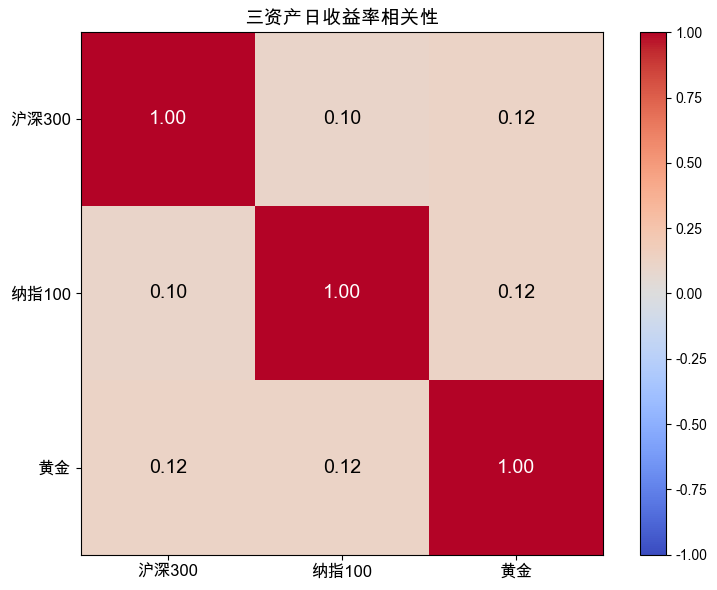

沪深300 与 纳指100 的相关性: 0.10 —— 两个股票市场有一定联动，但并非完全同步
沪深300 与 黄金 的相关性: 0.12 —— 黄金与股市低相关，股市跌的时候它不一定跌
纳指100 与 黄金 的相关性: 0.12

     方案  累计收益率  年化波动率    最大回撤
单押沪深300 -0.79% 18.45% -42.16%
三资产等权组合 84.45% 12.59% -23.26%


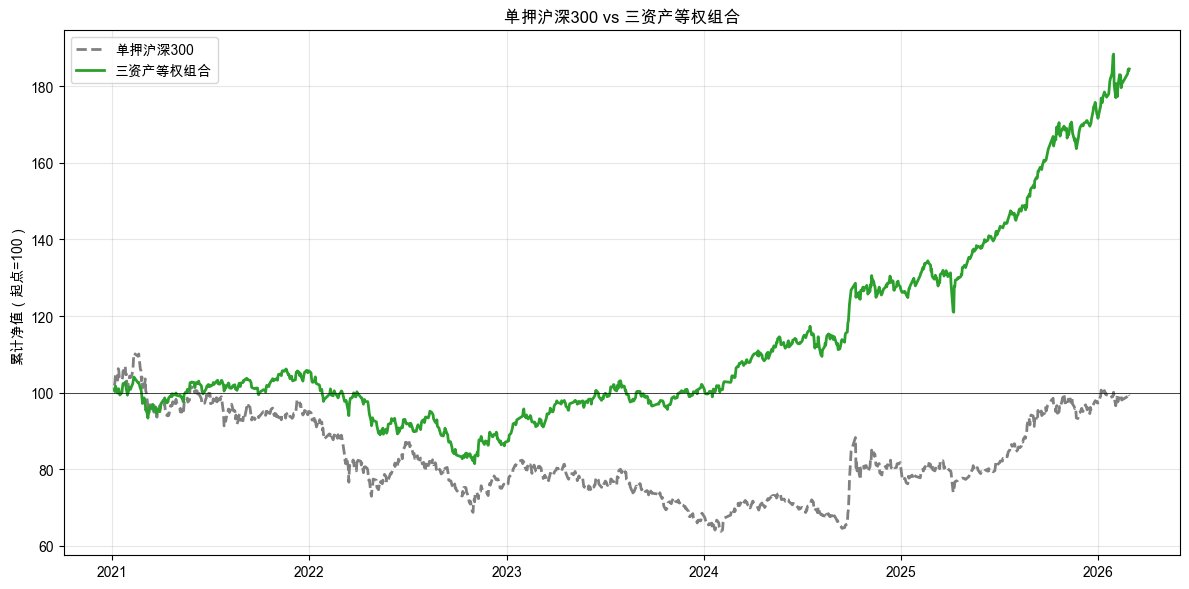


数据说了算：分散风险的关键不是多买几个，而是买涨跌不同步的。

投资宇宙构建完成: ('510300.SS', 'QQQ', 'GLD')


In [3]:
from oxq.universe import StaticUniverse

# 下载黄金 ETF
downloader.download("GLD", start="2021-01-01", end=today)

# 读取三只 ETF
csi300 = provider.get_bars("510300.SS", start="2021-01-01", end=today)
qqq = provider.get_bars("QQQ", start="2021-01-01", end=today)
gld = provider.get_bars("GLD", start="2021-01-01", end=today)

# 合并收盘价
prices = pd.DataFrame({
    '沪深300': csi300['close'],
    '纳指100': qqq['close'],
    '黄金': gld['close']
}).dropna()

# 计算日收益率和相关性矩阵
returns = prices.pct_change().dropna()
corr = returns.corr()

# 相关性热力图
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, fontsize=12)
ax.set_yticklabels(corr.columns, fontsize=12)

for i in range(len(corr)):
    for j in range(len(corr)):
        ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center',
                fontsize=14, fontweight='bold',
                color='white' if abs(corr.iloc[i, j]) > 0.5 else 'black')

plt.colorbar(im)
ax.set_title('三资产日收益率相关性', fontsize=14)
plt.tight_layout()
plt.show()

print(f'沪深300 与 纳指100 的相关性: {corr.loc["沪深300", "纳指100"]:.2f} —— 两个股票市场有一定联动，但并非完全同步')
print(f'沪深300 与 黄金 的相关性: {corr.loc["沪深300", "黄金"]:.2f} —— 黄金与股市低相关，股市跌的时候它不一定跌')
print(f'纳指100 与 黄金 的相关性: {corr.loc["纳指100", "黄金"]:.2f}')

# 组合 vs 单押对比
single = returns['沪深300']  # 单押沪深300
equal_weight = returns.mean(axis=1)  # 等权三资产组合

# 计算指标
def calc_metrics(daily_returns, label):
    cum_return = (1 + daily_returns).prod() - 1
    annual_vol = daily_returns.std() * np.sqrt(252)
    cumulative = (1 + daily_returns).cumprod()
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    return {'方案': label, '累计收益率': f'{cum_return:.2%}',
            '年化波动率': f'{annual_vol:.2%}', '最大回撤': f'{max_drawdown:.2%}'}

metrics = pd.DataFrame([
    calc_metrics(single, '单押沪深300'),
    calc_metrics(equal_weight, '三资产等权组合')
])
print(f'\n{metrics.to_string(index=False)}')

# 累计收益率对比图
fig, ax = plt.subplots(figsize=(12, 6))
cum_single = (1 + single).cumprod() * 100
cum_portfolio = (1 + equal_weight).cumprod() * 100
ax.plot(cum_single.index, cum_single.values, label='单押沪深300',
        linewidth=2, linestyle='--', color='gray')
ax.plot(cum_portfolio.index, cum_portfolio.values, label='三资产等权组合',
        linewidth=2, color='#2ca02c')
ax.axhline(y=100, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('累计净值（起点=100）')
ax.set_title('单押沪深300 vs 三资产等权组合')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('\n数据说了算：分散风险的关键不是多买几个，而是买涨跌不同步的。')

# 使用 open-xquant 构建投资宇宙
universe = StaticUniverse(
    symbols=["510300.SS", "QQQ", "GLD"],
    name="global-macro-etf"
)
snapshot = universe.get_universe(as_of_date=today)
print(f'\n投资宇宙构建完成: {snapshot.symbols}')

### Step 3 解读

相关性热力图验证了这个说法：**黄金与两个股票市场的相关性都很低。** 股市跌的时候，黄金不一定跟着跌——这正是它的保护价值所在。

组合对比进一步印证了这一点：三资产等权组合虽然收益不一定最高，但**波动率和最大回撤都显著降低**。

**数据说了算：分散风险的关键不是"多买几个"，而是买"涨跌不同步的"。**

回顾一下我们走过的三步：

1. 个股噪音大 → 用 ETF（组合对抗波动）
2. ETF 太多 → 用 GDP 锚定中美
3. 中美可能同跌 → 加入低相关的黄金

三只 ETF 选定：**沪深300、纳斯达克100、黄金**。

---

## 回头看：你刚才做了什么？

### 投资宇宙

三步筛选下来，你从全市场几千只标的中选出了 3 只 ETF。这个"策略考虑的标的范围"，在量化交易中叫做**投资宇宙（Universe）**。

构建 Universe 不是偷懒，而是让后续分析更有效：
- **降低噪声**：你亲眼验证了，把低质量的标的（个股）排除后，信号更干净
- **缩小范围**：几百只 ETF 缩到 3 只，后续做策略研究时计算量可控
- **风控前置**：选标的本身就是第一道风控——流动性差的、数据质量低的，在这一步就被挡在门外了

### 市场上的赚钱方式

我们一直在用均线策略做实验。其实市场上赚钱的方式不止这一种：

| 方式 | 通俗理解 | 时间尺度 |
|------|----------|----------|
| **价值投资** | 找到好公司，便宜时买入，持有数年 | 月线、年线 |
| **趋势交易** | 发现涨的趋势就跟上，反转就撤 | 日线、周线 |
| **统计套利** | 两个相关的东西价格差异，赚差价 | 日内~几天 |

价值投资和趋势交易的核心区别在于**时间尺度**：同一只标的，月线看到的是长期价值（好公司被低估），日线看到的是短期趋势的形成和反转。同一个世界，不同的视角。

我们课程用的均线策略是典型的趋势交易。但不管哪种方式，**先构建 Universe、再做分析**这个原则都一样。

---

## 本章总结

### 三步筛选

```
全市场几千只标的
    ↓ Step 1: 个股噪音大 → 选 ETF（组合对抗波动）
    ↓ Step 2: GDP 锚定 → 锁定中美
    ↓ Step 3: 低相关性 → 加入黄金
    ↓
投资宇宙：{沪深300 ETF, 纳斯达克100 ETF, 黄金 ETF}
```

### 本章核心认知

| 认知 | 来源 |
|------|------|
| 组合对抗波动 | Step 1 实验 |
| 选择要有数据支撑的理由 | Step 2 实验 |
| 分散风险靠"不同步"，不靠"数量多" | Step 3 实验 |
| 先猜后验，数据说了算 | 贯穿全章 |

### 进阶思考

3 只 ETF 还可以扩展。思路不变——每加一个标的，都要有数据支撑的理由：

| 方向 | 可能的标的 | 逻辑 |
|------|-----------|------|
| 更多指数 | 中证500、标普500、欧洲50 | 覆盖更多市场和风格 |
| 更多资产类别 | 国债 ETF、商品 ETF | 进一步降低相关性 |

### 带走的问题

标的选好了，但关键问题还没回答：

- **沪深300、纳指100、黄金，各买多少？** 等分？还是有更聪明的分法？→ Q3
- **什么时候买入、什么时候卖出？** → Q4
- **怎么验证这个组合确实有效？** → Q5